In [124]:
# Exercise 1.1
import numpy as np
import torch
from numpy.linalg import inv

# Define a class with solve_Ricatti, control_value and markov control as required
class LQR_Ricatti:
    def __init__(self, H, M, C, D, R, T):
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.T = T
        
    def solve_Ricatti(self, t_grid):
        delta_t = t_grid[1] - t_grid[0]
        n = len(t_grid)
        S = np.zeros((n, 2, 2))
        S[-1] = self.R
        for i in range(n - 2, -1, -1):
            S_i = S[i + 1]
            M_i = self.M(t_grid[i])
            D_inv = np.linalg.inv(self.D)
            S[i] = S_i - delta_t * (2 * np.dot(self.H.T, S_i) - np.dot(S_i, M_i).dot(D_inv).dot(M_i.T).dot(S_i) + self.C)
        return S
    
    def control_value(self, t, x):
        S = self.solve_Ricatti(t)
        control_values = np.zeros((len(t), len(x)))
        for i in range(len(t)):
            for j in range(len(x)):
                control_values[i, j] = np.dot(np.dot(x[j], S[i]), x[j]) + self.R[0, 0]
        return torch.Tensor(control_values).unsqueeze(1)
    
    def markov_control(self, t, x):
        S = self.solve_Ricatti(t)
        markov_control_values = np.zeros((len(t), len(x), 2))
        for i in range(len(t)):
            for j in range(len(x)):
                markov_control_values[i, j] = -np.dot(inv(self.D), np.dot(self.M(t[i]).T, np.dot(S[i], x[j])))
        return torch.Tensor(markov_control_values)


In [125]:
# Exercise 2.1
import numpy as np
# Define the problem parameters
H = np.array([[1, 0], [0, 1]])
M = lambda t: np.array([[1, 0], [0, 1]])
C = np.array([[1, 0], [0, 1]])
D = np.array([[1, 0], [0, 1]])
R = np.array([[1, 0], [0, 1]])
T = 1.0
lqr = LQR_Ricatti(H, M, C, D, R, T)
num_samples= 300
t = np.linspace(0,1,num=num_samples)
# Create an instance of the LQR_Ricatti class
def generate_data(T, num_samples):
    t_samples = np.random.uniform(0, T, num_samples) # t_samples is generated randomly, used in Exercise 2 as required
    x_samples = np.random.uniform(-3, 3, size=(num_samples, 2)) # x_samples is generated randomly, used in Exercise 2,3,4 as required
    v_samples = lqr.control_value(t_samples,x_samples) # v_samples is the value when x and t are x are x_samples and t_samples, respectively
    v_true = lqr.control_value(t,x_samples) # v_true is generated with a fixed-step t and x_samples, used in Exercise 4 to compare with the result from PIA
    m_samples = lqr.markov_control(t_samples,x_samples) # m_samples is the optimal Markov control when x and t are x are x_samples and t_samples, respectively
    return t_samples.reshape(-1, 1), x_samples, v_samples, v_true, m_samples
t_samples, x_samples, v_samples, v_true, m_samples = generate_data(T,num_samples)

/var/folders/pz/yr5dm55x0hg9ztjy88jlhgm40000gn/T/ipykernel_84758/883547808.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(v_samples, dtype=torch.float32)
/Users/chenling/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([300, 1, 300])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 317.1733
Epoch 100, Loss: 76.7783
Epoch 200, Loss: 76.7611


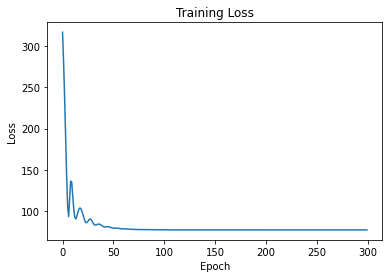

In [126]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # The input dimension is 3 ,layer dimension is 100, layer number is 3 and the output dimension is 1
        self.fc1 = nn.Linear(in_features=3, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
def train(net, criterion, optimizer, t_samples, x_samples, v_samples, num_epochs=300):
    train_loss = []
    for epoch in range(num_epochs):
        # inputs is 3 dimensions, outputs is 1 dimension
        # targets is v_samples, where we get theoretically; outputs is the simulated one, which is calculated by the neutral network
        # loss function is the difference between outputs and targets
        optimizer.zero_grad()
        inputs = torch.tensor(np.hstack((t_samples, x_samples)), dtype=torch.float32)
        targets = torch.tensor(v_samples, dtype=torch.float32)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return train_loss
net = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
train_loss = train(net, criterion, optimizer, t_samples, x_samples, v_samples)
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [127]:
# Exercise 2.2
import torch
import torch.nn as nn
from collections import namedtuple
from typing import Tuple
import matplotlib.pyplot as plt

# Define a class of feedforward neural network
class FFN(nn.Module):

    def __init__(self, sizes, activation=nn.ReLU, output_activation=nn.Identity, batch_norm=False):
        super().__init__()
        
        layers = [nn.BatchNorm1d(sizes[0]),] if batch_norm else []
        for j in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[j], sizes[j+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(sizes[j+1], affine=True))
            if j<(len(sizes)-2):
                layers.append(activation())
            else:
                layers.append(output_activation())

        self.net = nn.Sequential(*layers)

    def freeze(self):
        for p in self.parameters():
            p.requires_grad=False

    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad=True

    def forward(self, x):
        return self.net(x)


/var/folders/pz/yr5dm55x0hg9ztjy88jlhgm40000gn/T/ipykernel_84758/565251862.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_samples_1 = torch.tensor(m_samples, dtype=torch.float32)
/Users/chenling/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([300, 300, 2])) that is different to the input size (torch.Size([300, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/300], Loss: 0.0948
Epoch [200/300], Loss: 0.0897
Epoch [300/300], Loss: 0.0884


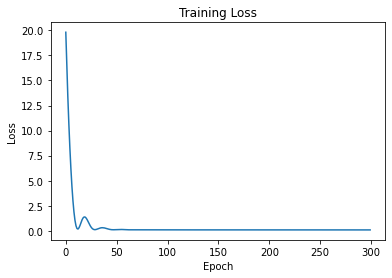

In [129]:
# Define problem parameters
t_samples_1 = torch.tensor(t_samples, dtype=torch.float32)
x_samples_1 = torch.tensor(x_samples, dtype=torch.float32)
m_samples_1 = torch.tensor(m_samples, dtype=torch.float32)
model = FFN([2, 100, 2])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
n_epochs = 300
train_loss = []

for epoch in range(n_epochs):
    # Forward pass
    m_pred = model(x_samples_1)

    # Compute loss
    loss = loss_fn(m_pred, m_samples_1)

    # Backward pass and optimization step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record loss for plotting
    train_loss.append(loss.item())

    # Print progress every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [149]:
# Exercise 3
import numpy as np
# Define problem parameters
n = 300  # Number of spatial grid points
m = 300  # Number of time steps
T = 1
dt = T / (m - 1)  # Time step size
t = np.linspace(0,1,num=m)
H = [1,1]
M = [-1,-1]
C = np.array([[1, 5], [5, 1]])
D = np.array([[0.01, 0], [0, 0.01]])
R = np.array([[1, 0], [0, 1]])
sigma = [1,1]
u = np.ones((300,1))
u_samples = np.zeros((n,1))

def L(i,alpha):
    L_u = np.zeros_like(u)
    dx_u = np.zeros_like(u)
    dxx_u = np.zeros_like(u)
    # define the first and second derivative by the definition in discrete-time horizon
    dx_u[i] = (u[i+1]-u[i])/np.mean((x_samples[i+1]-x_samples[i]))
    dxx_u[i] = (dx_u[i+1]-dx_u[i])/np.mean((x_samples[i+1]-x_samples[i]))
    # preliminary parameter
    Hx = np.dot(H, np.transpose(x_samples[i]))
    Malpha = np.dot(M, alpha)
    # Compute L operator
    L_u[i] = 0.5*np.dot(np.dot(sigma, np.transpose(sigma)) , dxx_u[i])
    L_u[i] += np.dot(Hx, dx_u[i])
    L_u[i] += np.dot(Malpha, dx_u[i])
    L_u[i] += np.dot(np.dot(x_samples[i] , C) , np.transpose(x_samples[i]))
    L_u[i] += np.dot(np.transpose(alpha), np.dot(D, alpha))
    return L_u[i].flatten()

# generate u_samples
for i in range(n-1):
    u_samples[i+1,0] = u_samples[i,0] - dt * (-1) * L(i,np.transpose([1,1]))

Epoch 0, Loss: 10.4997
Epoch 100, Loss: 2.5959
Epoch 200, Loss: 2.2941


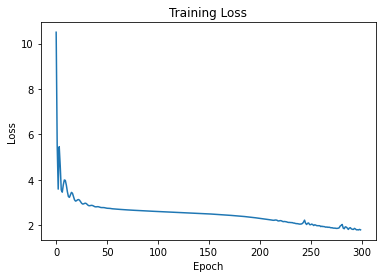

In [138]:
def train_pde(net, criterion, optimizer, t_samples, x_samples, u_samples, num_epochs=300):
    train_loss = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        inputs = torch.tensor(np.hstack((t_samples, x_samples)), dtype=torch.float32)
        targets = torch.tensor(u_samples, dtype=torch.float32)
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return train_loss
net = Net()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
train_loss = train_pde(net, criterion, optimizer, t_samples, x_samples, u_samples)
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [150]:
# Exercise 4

import numpy as np
# Define problem parameters
n = 300  # Number of spatial grid points
m = 300  # Number of time steps
T = 1
dt = T / (m - 1)  # Time step size
t = np.linspace(0,1,num=m)
H = [-1,-1]
M = [-1,-1]
C = np.array([[1, 5], [5, 1]])
D = np.array([[0.01, 0], [0, 0.01]])
R = np.array([[1, 0], [0, 1]])
sigma = [1,1]
u = np.ones((300,1))
u_samples = np.zeros((n,1))

def L(i,alpha):
    L_u = np.zeros_like(u)
    dx_u = np.zeros_like(u)
    dxx_u = np.zeros_like(u)
    # define the first and second derivative by the definition in discrete-time horizon
    dx_u[i] = (u[i+1]-u[i])/np.mean((x_samples[i+1]-x_samples[i]))
    dxx_u[i] = (dx_u[i+1]-dx_u[i])/np.mean((x_samples[i+1]-x_samples[i]))
    # preliminary parameter
    Hx = np.dot(H, np.transpose(x_samples[i]))
    Malpha = np.dot(M, alpha)
    # Compute L operator
    L_u[i] = 0.5*np.dot(np.dot(sigma, np.transpose(sigma)) , dxx_u[i])
    L_u[i] += np.dot(Hx, dx_u[i])
    L_u[i] += np.dot(Malpha, dx_u[i])
    L_u[i] += np.dot(np.dot(x_samples[i] , C) , np.transpose(x_samples[i]))
    L_u[i] += np.dot(np.transpose(alpha), np.dot(D, alpha))
    return L_u[i].flatten()

# generate u_samples
for i in range(n-1):
    u_samples[i+1,0] = u_samples[i,0] - dt * (-1) * L(i,np.transpose([1,1]))

In [152]:
# v_alpha is a matrix with each column being the u we generated and the column number being the time
v_alpha = np.ones((n,n))
alpha = np.transpose([1,1])
for j in range(n-1):
    for i in range(n-1):
        v_alpha[i,j] = v_alpha[i-1,j]-dt*(-1)*L(i,alpha)
    alpha_1 = -np.mean(v_alpha[:,j])/2
    alpha_2 = -np.mean(v_alpha[:,j])/2
    alpha = np.transpose([alpha_1,alpha_2])
    v_alpha[0,j+1] = np.mean(v_alpha[:,j])

In [153]:
# test the loss between v_alpha and v_true
loss_v = np.zeros((1,n))
for i in range(n-1):
    loss_v[0,i] = np.mean(v_alpha[:,i]-v_true.numpy())
print(loss_v)


[[1.40476291 1.43011146 1.43058965 1.43059871 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.43059888 1.43059888
  1.43059888 1.43059888 1.43059888 1.43059888 1.